In [1]:
import numpy as np
import pandas as pd
from itertools import product

import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error as MSE

import warnings
warnings.filterwarnings("ignore")


In [2]:
from sklearn.preprocessing import MinMaxScaler


csv_path = "jena_climate_2009_2016.csv"

data = pd.read_csv(csv_path)
cols = ['Date Time', 'p (mbar)', 'T (degC)', 'rh (%)', 'H2OC (mmol/mol)']
data = data[cols]

data.set_index("Date Time", inplace=True)

# Преобразуем индекс в DatetimeIndex, если это еще не сделано
data.index = pd.to_datetime(data.index, dayfirst=True, errors='coerce')

# Отсортируем индекс по возрастанию
data = data.sort_index()

# # Фильтруем данные за 2014-2016 годы
# filtered_data = data#.loc['2014':'2016']



# Рассчитаем среднее значение за каждый день
# daily_data = data.resample('M').mean()
data["date"] = data.index
data["month"] = data.date.dt.to_period('W')
data_month = data.groupby("month")["H2OC (mmol/mol)"].mean()
y = pd.Series(data_month.to_list())

y = pd.Series(MinMaxScaler().fit_transform(
    pd.DataFrame({"y":y}))[:, 0])
y_train = y 
# Проверим результат
len(y)

418

In [3]:
# y = daily_data["H2OC (mmol/mol)"] # Концентрация водяного пара

In [4]:
px.line(x=y.index, y=y)


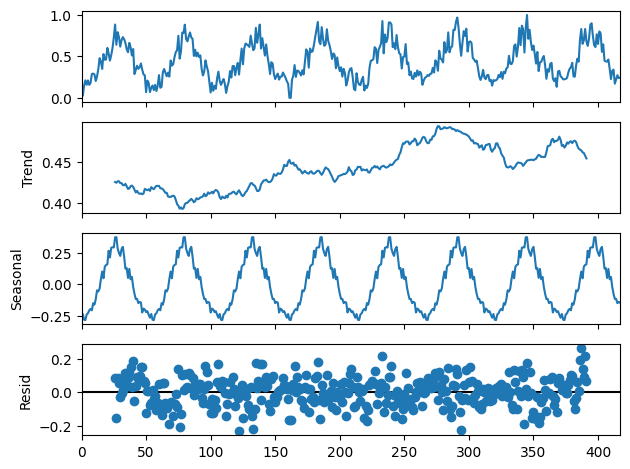

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

mult_decomposed = seasonal_decompose(y, period=53)
decompose_result = mult_decomposed.plot()

In [6]:
def test_stationarity(data, alpha=0.05):
    # Удаляем пропущенные значения
    column_data = data.dropna()

    # Тест Дики-Фуллера
    result = sm.tsa.stattools.adfuller(column_data)
    p_value = result[1]

    # Определение стационарности
    if p_value < alpha:
        stationarity_result = "Стационарный ряд"
    else:
        stationarity_result = "Нестационарный ряд"

    print(f"Dickey-Fuller Test: p=%f" % p_value)
    print(f"Результат: {stationarity_result}")

# Выполнение тестов для каждой переменной в датасете
test_stationarity(y)

Dickey-Fuller Test: p=0.000000
Результат: Стационарный ряд


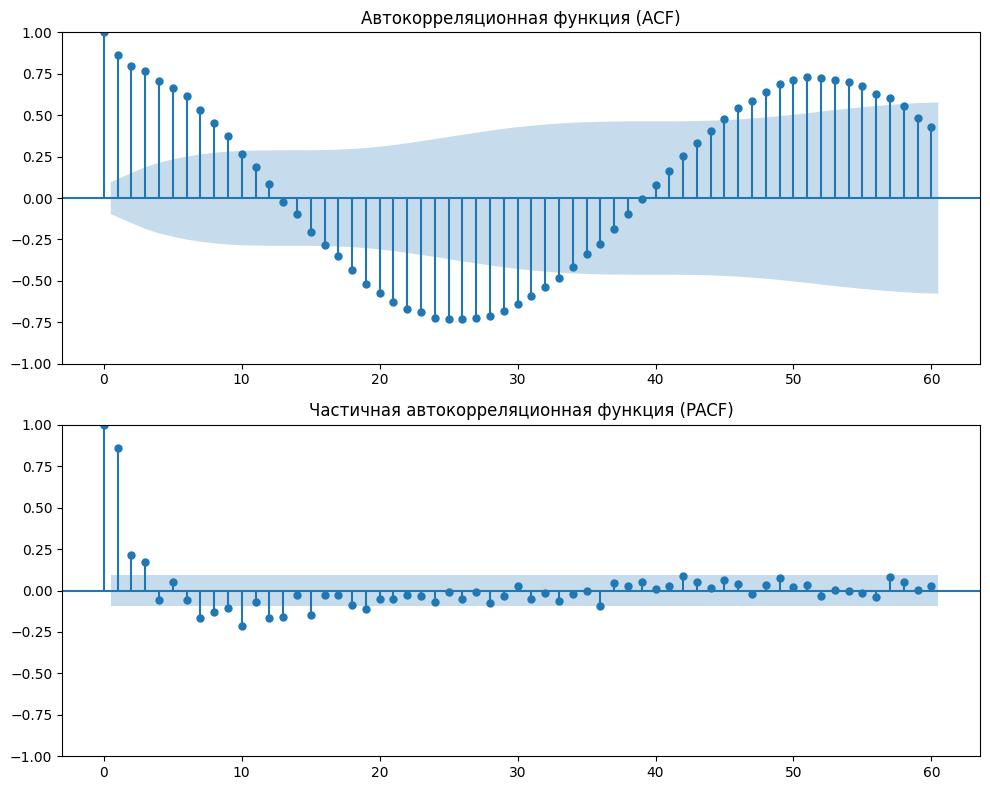

In [7]:
# Построение коррелограмм
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Автокорреляционная функция (ACF)
plot_acf(y, lags=60, ax=ax[0])
ax[0].set_title('Автокорреляционная функция (ACF)')

# Частичная автокорреляционная функция (PACF)
plot_pacf(y, lags=60, ax=ax[1])
ax[1].set_title('Частичная автокорреляционная функция (PACF)')

plt.tight_layout()
plt.show()

### Делаем вывод о значениях p и q
+ p = 2 - последний значимый пик PACF
+ q = 53 - последний значимый пик ACF

### Разделим выборку

In [8]:
split_ind = 318
train_y = y[:split_ind]
test_y = y[split_ind:]

In [19]:
p,d,q = 2, 0, 54
model = ARIMA(train_y, order=(p,d,q))
model_fit = model.fit()
# print(model_fit.summary())

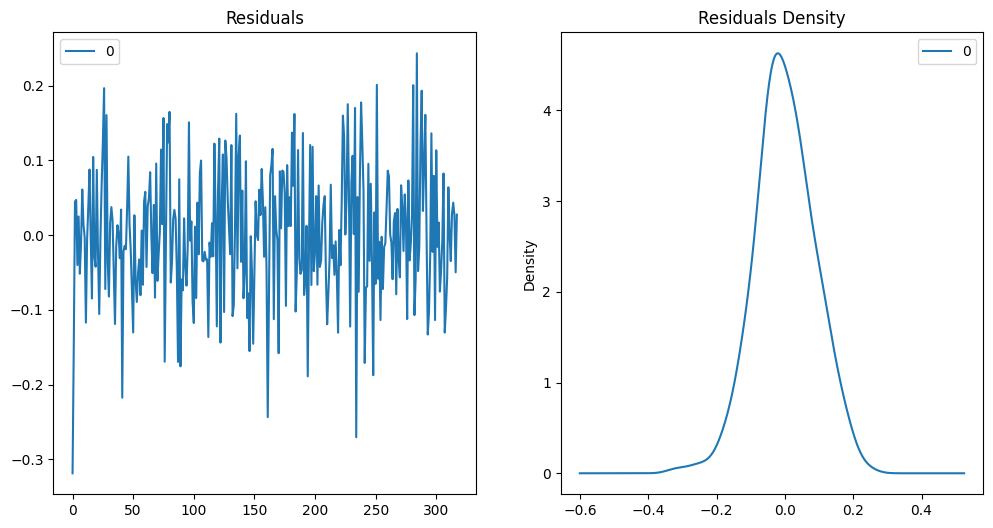

In [20]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(12, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Residuals Density', ax=ax[1])
plt.show()

In [21]:
predicted = model_fit.predict(dynamic=False)
pred = pd.Series(predicted[:len(train_y)], index= train_y.index)
len(pred)

318

In [22]:
forecast = model_fit.forecast(len(test_y))
len(forecast)

100

In [23]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=y.index,
        y=y, name="original time series")
)
fig.add_trace(
    go.Scatter(
        x=predicted.index,
        y=predicted, name="Fitted ARIMA")
)
fig.add_trace(
    go.Scatter(
        x=forecast[-len(test_y):].index, 
        y=forecast[-len(test_y):], name="Forecast ARIMA")
)
mse_val = MSE(y[-len(forecast):], forecast)
original_mse_val = mse_val
print(f"MSE={round(mse_val, 3)}")

MSE=0.036


### Подбор параметров

In [14]:
# import itertools

# from tqdm import tqdm

# best_pdq = None
# best_mse_val = np.inf

# for p, d, q in tqdm(list(
#     itertools.product(
#     list(range(0, 3)),
#     list(range(0, 3)),
#     list(range(0, 60, 10)) + [53, 54]
# )
# )):
#     model = ARIMA(train_y, order=(p, d, q))
#     model_fit = model.fit()
#     forecast = model_fit.forecast(len(test_y))
#     mse_val = MSE(y[-len(forecast):], forecast)
#     if mse_val < best_mse_val:
#         best_mse_val = mse_val
#         best_pds = p, d, q
#         print(f"BEST p,d,q = {p,d,q}")
#     print(mse_val)

### Лучшие значения p,d,q = (0, 1, 54)

In [24]:
p,d,q = 0,1,54
model = ARIMA(train_y, order=(p,d,q))
model_fit = model.fit()

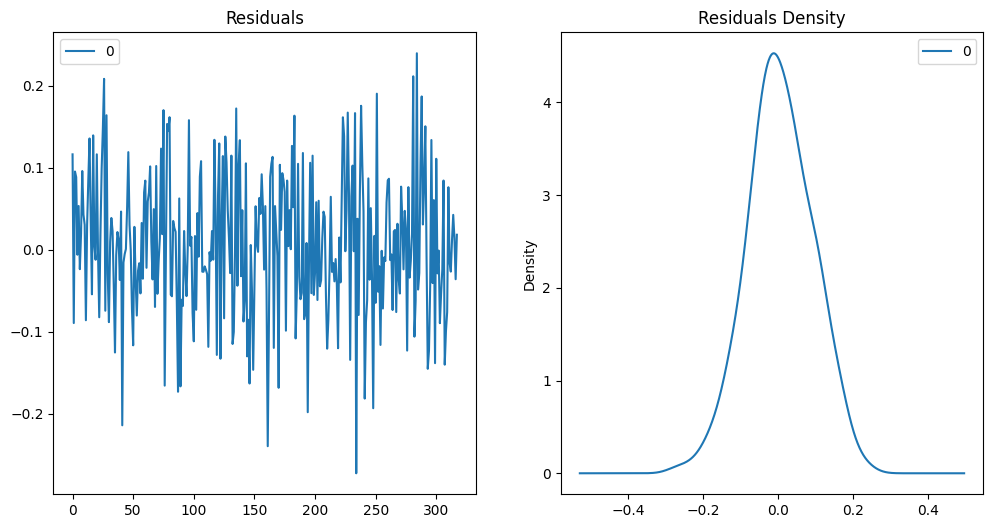

In [25]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(12, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Residuals Density', ax=ax[1])
plt.show()

In [26]:
forecast = model_fit.forecast(len(test_y))
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=y.index,
        y=y, name="original time series")
)
fig.add_trace(
    go.Scatter(
        x=predicted.index,
        y=predicted, name="Fitted ARIMA")
)
fig.add_trace(
    go.Scatter(
        x=forecast[-len(test_y):].index, 
        y=forecast[-len(test_y):], name="Forecast ARIMA")
)
mse_val = MSE(y[-len(forecast):], forecast)
best_chosen_mse_val = mse_val
print(f"MSE={round(mse_val, 3)}")

MSE=0.035


In [33]:
boost_percent = round(100*(original_mse_val-best_chosen_mse_val)/original_mse_val, 3)

In [35]:
print(f"В результате подбора гиперпарметров удалось улучшить MSE прогноза на {boost_percent}%")

В результате подбора гиперпарметров удалось улучшить MSE прогноза на 3.003%
